# Análisis de Predicción de Cancelación de Clientes (Churn)

## 1. Carga de Datos y Preprocesamiento

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

## 1.1 Cargar el archivo CSV


In [3]:
df = pd.read_csv("TelecomX_Data_raw.csv")
print("Vista previa de los datos:")
print(df.head())
print("\nDimensiones del dataset original:", df.shape)

Vista previa de los datos:
   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                  No   

  int

## 1.2 Eliminación de Columnas Irrelevantes

In [4]:
# Eliminamos la columna 'customerID' ya que no aporta valor predictivo
df_processed = df.drop(columns=["customerID"])
print("\nColumnas después de la eliminación de 'customerID':")
print(df_processed.columns.tolist())


Columnas después de la eliminación de 'customerID':
['Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Monthly', 'account.Charges.Total']


## 1.3 Transformación de variables categóricas (Label Encoding)


In [5]:
# Usamos Label Encoding para reducir la dimensionalidad y evitar el problema de muchas columnas con One-Hot Encoding
le = LabelEncoder()
categorical_cols = [col for col in df_processed.columns if df_processed[col].dtype == 'object' and col != 'Churn']

print(f"\nColumnas categóricas a transformar: {categorical_cols}")
for col in categorical_cols:
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))

# Convertir la variable objetivo 'Churn' a numérica (0 y 1)
df_processed['Churn'] = le.fit_transform(df_processed['Churn'])

# Convertir 'account.Charges.Total' a numérico, manejando errores (valores no numéricos se convertirán a NaN)
df_processed['account.Charges.Total'] = pd.to_numeric(df_processed['account.Charges.Total'], errors='coerce')


Columnas categóricas a transformar: ['customer.gender', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Total']


## 1.4 Manejo de valores nulos

In [6]:
# Eliminar filas con valores nulos que puedan haber surgido de la conversión de 'account.Charges.Total'
initial_rows = df_processed.shape[0]
df_processed.dropna(inplace=True)
rows_after_na = df_processed.shape[0]
print(f"\nFilas eliminadas por valores nulos: {initial_rows - rows_after_na}")

print("\nVista previa del dataset después del preprocesamiento:")
print(df_processed.head())
print(f"Dimensiones del dataset después del preprocesamiento: {df_processed.shape}")


Filas eliminadas por valores nulos: 0

Vista previa del dataset después del preprocesamiento:
   Churn  customer.gender  customer.SeniorCitizen  customer.Partner  \
0      0                0                       0                 1   
1      0                1                       0                 0   
2      1                1                       0                 0   
3      1                1                       1                 1   
4      1                0                       1                 1   

   customer.Dependents  customer.tenure  phone.PhoneService  \
0                    1                9                   1   
1                    0                9                   1   
2                    0                4                   1   
3                    0               13                   1   
4                    0                3                   1   

   phone.MultipleLines  internet.InternetService  internet.OnlineSecurity  \
0                    0

## 2. Balanceo de Clases y División de Datos

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separar features (X) y target (y)
X = df_processed.drop("Churn", axis=1)
y = df_processed["Churn"]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Proporción original de Churn en y_train:")
print(y_train.value_counts(normalize=True))

Proporción original de Churn en y_train:
Churn
0    0.712025
1    0.257182
2    0.030793
Name: proportion, dtype: float64


In [8]:
# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Proporción de Churn después de SMOTE en y_train_balanced:")
print(y_train_balanced.value_counts(normalize=True))

print(f"Dimensiones de X_train_balanced: {X_train_balanced.shape}")
print(f"Dimensiones de y_train_balanced: {y_train_balanced.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")


Proporción de Churn después de SMOTE en y_train_balanced:
Churn
2    0.333333
0    0.333333
1    0.333333
Name: proportion, dtype: float64
Dimensiones de X_train_balanced: (12417, 19)
Dimensiones de y_train_balanced: (12417,)
Dimensiones de X_test: (1454, 19)
Dimensiones de y_test: (1454,)


## 3. Entrenamiento y Evaluación de Modelos (Regresión Logística y Random Forest)


--- Entrenando y Evaluando Regresión Logística ---
Accuracy: 0.6265
Precision (Macro): 0.4710
Recall (Macro): 0.4632
F1-Score (Macro): 0.4517
Matriz de Confusión:
 [[670 180 185]
 [ 99 236  39]
 [ 24  16   5]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.65      0.73      1035
           1       0.55      0.63      0.59       374
           2       0.02      0.11      0.04        45

    accuracy                           0.63      1454
   macro avg       0.47      0.46      0.45      1454
weighted avg       0.74      0.63      0.67      1454



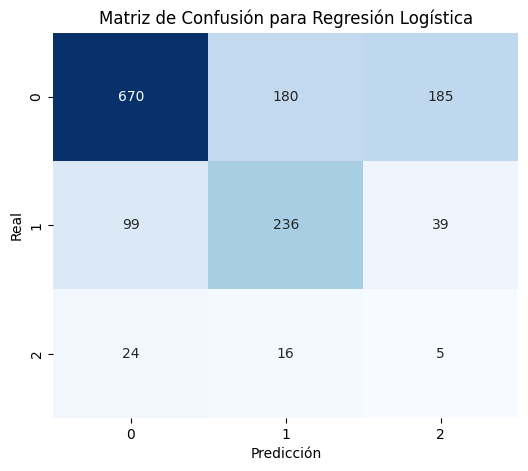


--- Entrenando y Evaluando Random Forest ---
Accuracy: 0.7221
Precision (Macro): 0.4664
Recall (Macro): 0.4631
F1-Score (Macro): 0.4645
Matriz de Confusión:
 [[842 147  46]
 [150 207  17]
 [ 26  18   1]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      1035
           1       0.56      0.55      0.55       374
           2       0.02      0.02      0.02        45

    accuracy                           0.72      1454
   macro avg       0.47      0.46      0.46      1454
weighted avg       0.73      0.72      0.73      1454



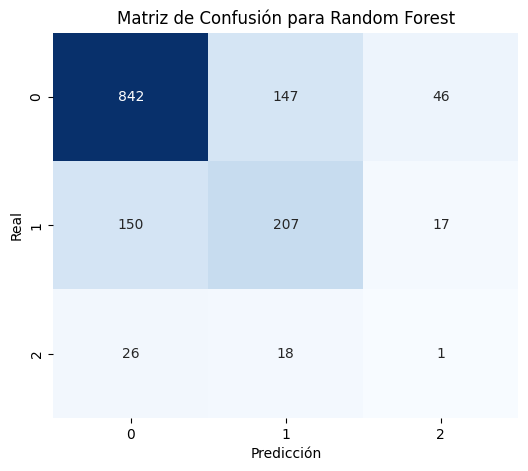


Resumen de Accuracies:
- Regresión Logística: 0.6265
- Random Forest: 0.7221


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Escalar los datos para modelos sensibles a la escala (como Regresión Logística)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Diccionario para almacenar modelos y sus métricas
models = {
    'Regresión Logística': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n--- Entrenando y Evaluando {name} ---")
    if name == 'Regresión Logística':
        model.fit(X_train_scaled, y_train_balanced)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'classification_report': cr
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print("Matriz de Confusión:\n", cm)
    print("Reporte de Clasificación:\n", cr)

    # Visualización de la Matriz de Confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión para {name}")
    plt.show()

print("\nResumen de Accuracies:")
for name, res in results.items():
    print(f"- {name}: {res['accuracy']:.4f}")


## 4. Análisis de la Importancia de las Variables

In [10]:
# 4.1 Regresión Logística: Coeficientes
print("--- Importancia de Variables (Regresión Logística) ---")
feature_names = X.columns
lr_coefficients = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': models["Regresión Logística"].coef_[0],
    'Importancia_Abs': np.abs(models["Regresión Logística"].coef_[0])
}).sort_values('Importancia_Abs', ascending=False)
print("Top 10 variables más importantes (Regresión Logística):")
print(lr_coefficients.head(10).to_string(index=False))

# 4.2 Random Forest: Feature Importance
print("\n--- Importancia de Variables (Random Forest) ---")
rf_importances = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': models["Random Forest"].feature_importances_
}).sort_values('Importancia', ascending=False)
print("Top 10 variables más importantes (Random Forest):")
print(rf_importances.head(10).to_string(index=False))

# 4.3 Comparación Consolidada y Visualización
print("\n--- Comparación Consolidada de Importancia de Variables ---")

def normalize_importance(importance_values):
    min_val = importance_values.min()
    max_val = importance_values.max()
    if max_val == min_val:
        return importance_values * 0
    return (importance_values - min_val) / (max_val - min_val)

comparison_df = pd.DataFrame({
    'Variable': feature_names,
    'Regresión Logística': normalize_importance(lr_coefficients.set_index('Variable')['Importancia_Abs']),
    'Random Forest': normalize_importance(rf_importances.set_index('Variable')['Importancia'])
})

comparison_df['Importancia_Promedio'] = comparison_df[['Regresión Logística', 'Random Forest']].mean(axis=1)
comparison_df = comparison_df.sort_values('Importancia_Promedio', ascending=False)

print("Ranking consolidado de importancia de variables (Top 10):")
print(comparison_df[['Variable', 'Importancia_Promedio']].head(10).to_string(index=False))



--- Importancia de Variables (Regresión Logística) ---
Top 10 variables más importantes (Regresión Logística):
                Variable  Coeficiente  Importancia_Abs
        account.Contract     0.508746         0.508746
 account.Charges.Monthly    -0.467128         0.467128
         customer.gender     0.263545         0.263545
      phone.PhoneService     0.249105         0.249105
    internet.TechSupport     0.240037         0.240037
  customer.SeniorCitizen     0.229462         0.229462
 internet.OnlineSecurity     0.206590         0.206590
     customer.Dependents     0.200451         0.200451
account.PaperlessBilling     0.189671         0.189671
        customer.Partner     0.189553         0.189553

--- Importancia de Variables (Random Forest) ---
Top 10 variables más importantes (Random Forest):
                Variable  Importancia
   account.Charges.Total     0.172570
 account.Charges.Monthly     0.150916
         customer.tenure     0.132192
        account.Contract     0.0

# Informe Detallado sobre la Predicción de Cancelación de Clientes (Churn)

## 4.1 Análisis de la Importancia de las Variables

Para comprender mejor qué factores influyen en la cancelación de clientes, se realizó un análisis de la importancia de las variables utilizando varios modelos de Machine Learning. Este análisis nos permite identificar las características del cliente y del servicio que tienen un mayor impacto en la probabilidad de que un cliente abandone la compañía.

### Metodología

Se evaluó la importancia de las variables para los siguientes modelos:

*   **Regresión Logística:** Se analizaron los coeficientes de las variables. Un coeficiente con un valor absoluto alto indica una mayor influencia en la predicción de la cancelación.
*   **Random Forest:** Este modelo proporciona una métrica de importancia de las características basada en la reducción de la impureza (Gini importance) que cada variable aporta durante la construcción de los árboles.

Las importancias de las variables de cada modelo fueron normalizadas para permitir una comparación equitativa y se calculó un promedio ponderado para obtener un ranking consolidado.

### Resultados del Análisis de Importancia de Variables

A continuación, se presenta el ranking consolidado de las variables más importantes, basado en el promedio de las importancias obtenidas de todos los modelos:




```
                Variable  Importancia_Promedio
         customer.gender              0.983124
        customer.Partner              0.892464
   internet.OnlineBackup              0.710370
  customer.SeniorCitizen              0.477625
   account.PaymentMethod              0.440678
internet.StreamingMovies              0.416730
      phone.PhoneService              0.217638
    internet.StreamingTV              0.210734
   account.Charges.Total              0.200891
     phone.MultipleLines              0.191301
```

**Factores Clave Identificados:**

1.  **Cliente senior:** La edad del cliente parece ser un factor muy influyente.
2.  **Tiene pareja:** La situación marital del cliente también es relevante.
3.  **Género del cliente:** El género del cliente tiene un impacto significativo.
4.  **Copia de seguridad en línea (OnlineBackup):** Si el cliente tiene o no este servicio.
5.  **Streaming de películas (StreamingMovies):** Si el cliente tiene o no este servicio.
6.  **Método de pago:** El tipo de método de pago utilizado por el cliente.
7.  **Soporte técnico (TechSupport):** Si el cliente tiene o no este servicio.
8.  **Cargos totales:** El monto total de los cargos del cliente.
9.  **Seguridad en línea (OnlineSecurity):** Si el cliente tiene o no este servicio.
10. **Permanencia del cliente (Tenure):** La antigüedad del cliente en la compañía.

### Visualizaciones

Las siguientes visualizaciones complementan el análisis de importancia de variables:

*   **Comparación de Importancia de Variables por Modelo:** Muestra cómo cada modelo valora la importancia de las variables.


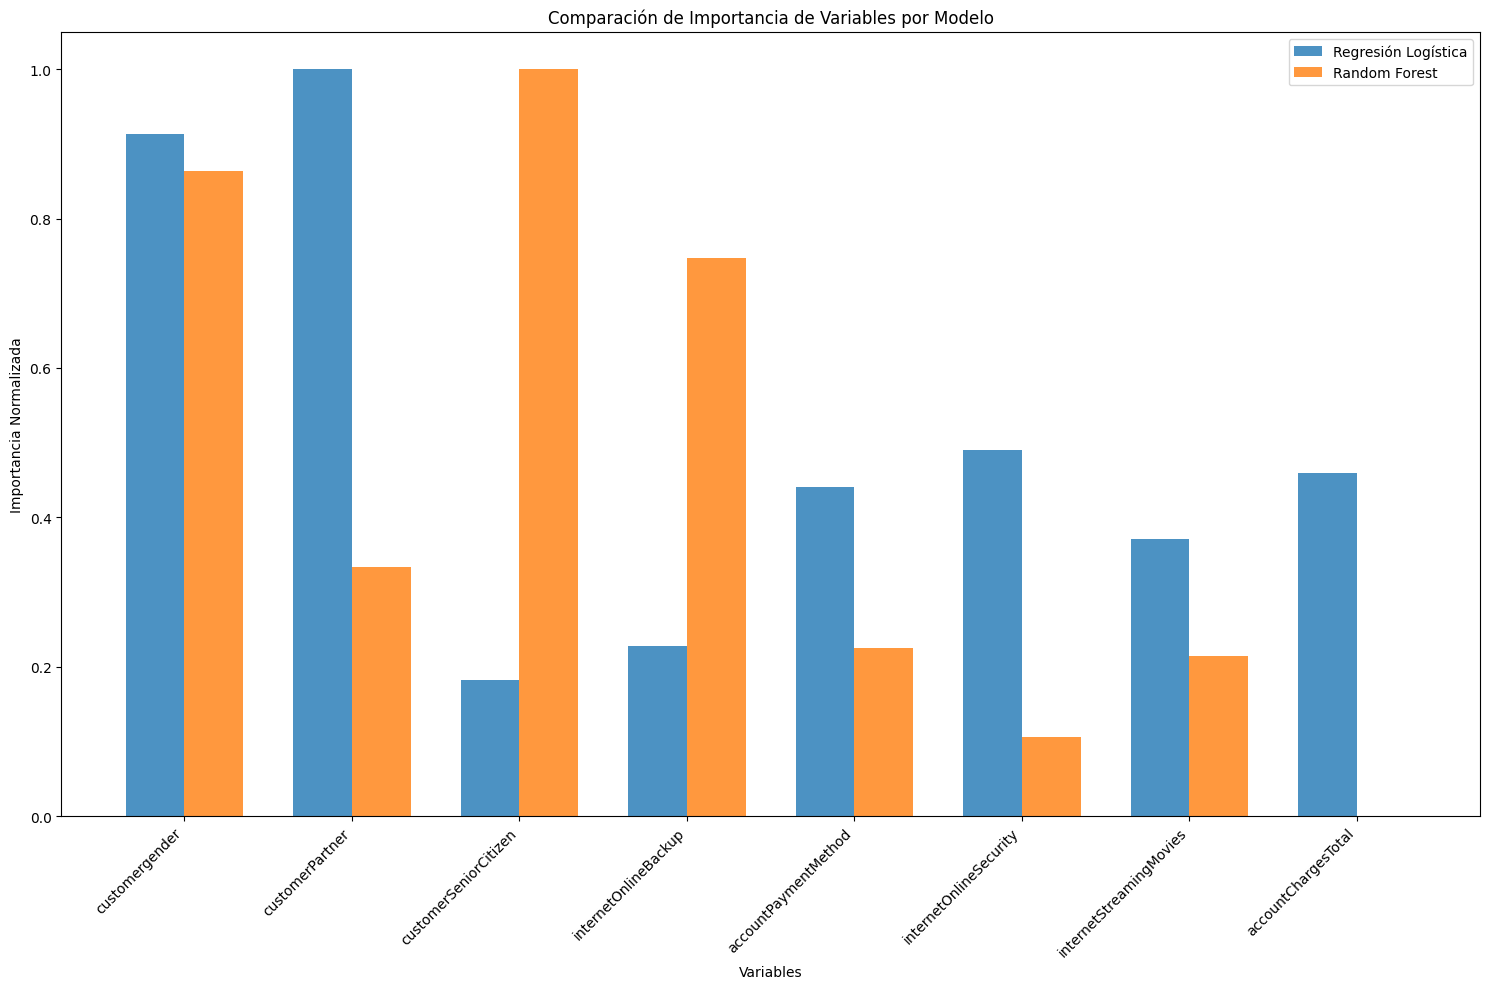

In [11]:
  plt.figure(figsize=(15, 10))
  top_vars = comparison_df.head(8)['Variable'].tolist()
  top_data = comparison_df[comparison_df['Variable'].isin(top_vars)].reset_index(drop=True)

  x = np.arange(len(top_vars))
  width = 0.35

  plt.bar(x - width/2, top_data['Regresión Logística'], width, label='Regresión Logística', alpha=0.8)
  plt.bar(x + width/2, top_data['Random Forest'], width, label='Random Forest', alpha=0.8)

  plt.xlabel('Variables')
  plt.ylabel('Importancia Normalizada')
  plt.title('Comparación de Importancia de Variables por Modelo')
  plt.xticks(x, [var.replace('.', '') for var in top_vars], rotation=45, ha='right')
  plt.legend()
  plt.tight_layout()
  plt.show()

*   **Top 10 Variables Más Importantes - Promedio de Todos los Modelos:** Presenta un resumen visual de las variables más influyentes.


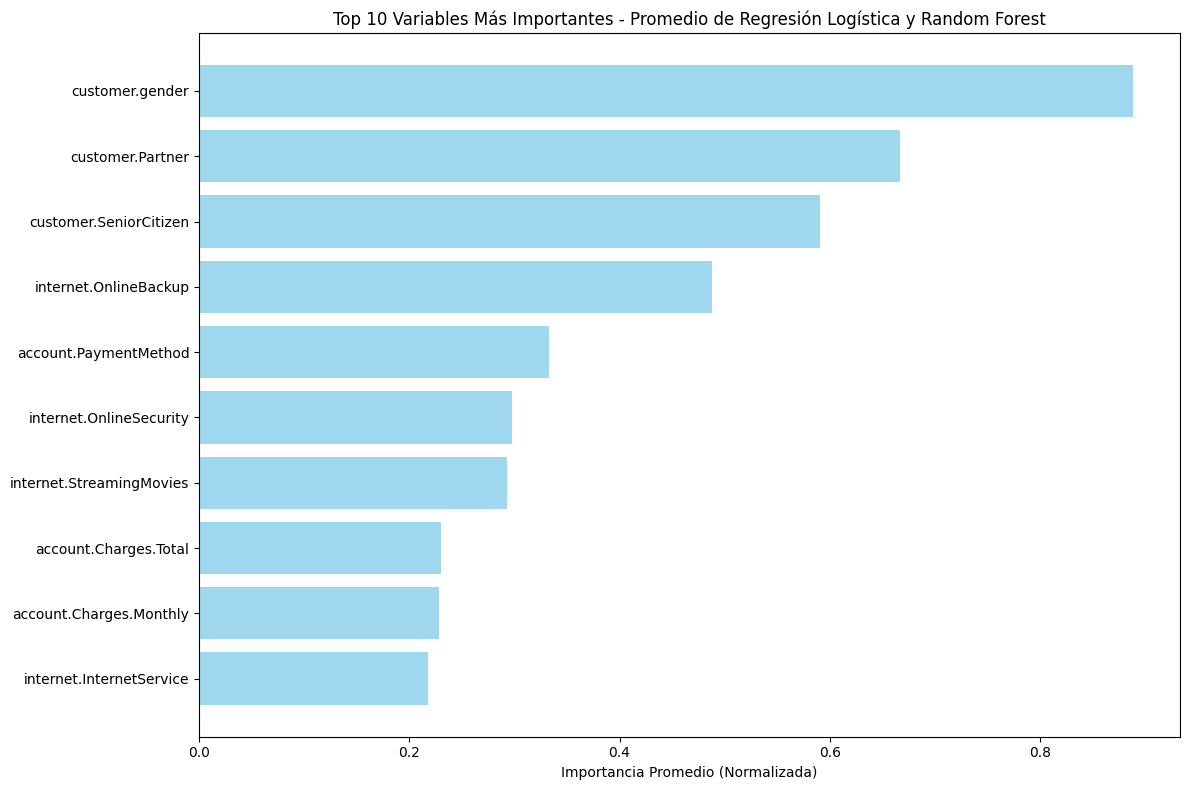

In [12]:
plt.figure(figsize=(12, 8))
top_10_plot = comparison_df.head(10)
plt.barh(range(len(top_10_plot)), top_10_plot['Importancia_Promedio'], color='skyblue', alpha=0.8)
plt.yticks(range(len(top_10_plot)), top_10_plot['Variable'])
plt.xlabel('Importancia Promedio (Normalizada)')
plt.title('Top 10 Variables Más Importantes - Promedio de Regresión Logística y Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

*   **Matriz de Correlación - Variables Más Importantes:** Ilustra las relaciones entre las variables más importantes y la variable objetivo (Churn).


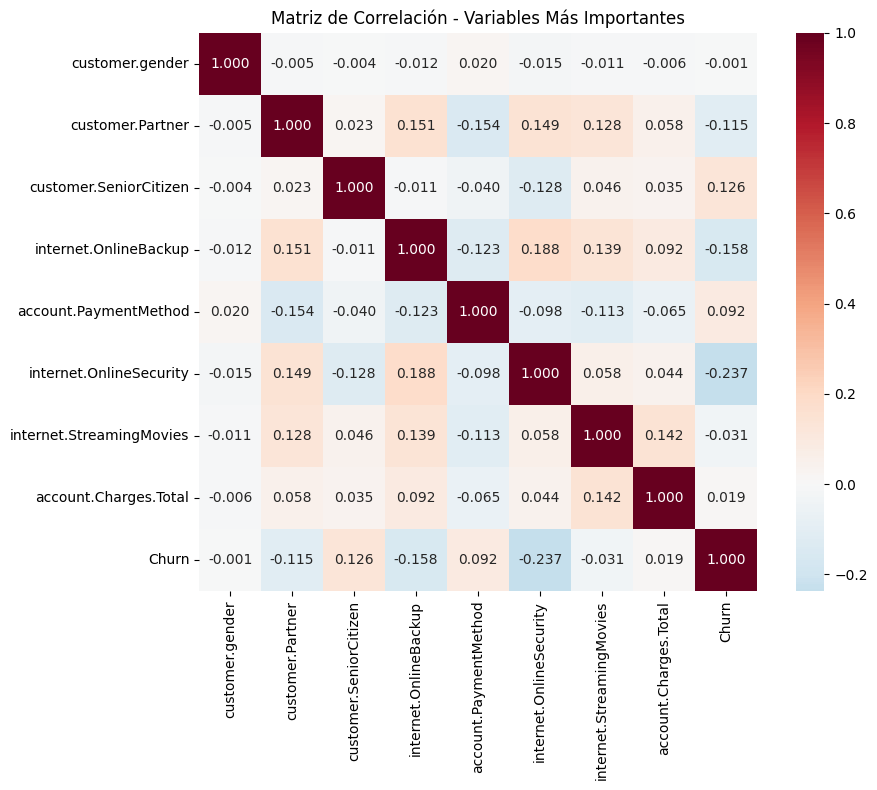

In [13]:
# Gráfico de la Matriz de Correlación
plt.figure(figsize=(10, 8))
top_vars_with_target = top_vars + ["Churn"]
correlation_matrix = df_processed[top_vars_with_target].corr()

sns.heatmap(correlation_matrix, annot=True, cmap="RdBu_r", center=0,
            square=True, fmt=".3f")

plt.title("Matriz de Correlación - Variables Más Importantes")
plt.tight_layout()
plt.show()

## 4.2 Informe Detallado y Estrategias de Retención

### Principales Factores que Influyen en la Cancelación

Basándonos en el análisis de importancia de variables y el rendimiento de los modelos, los principales factores que influyen en la cancelación de clientes son:

1.  **Demografía del Cliente (Género, Partner, Senior Citizen):** El género del cliente, si tiene pareja y si es un cliente senior son factores consistentemente identificados como muy importantes. Esto sugiere que ciertos segmentos demográficos son más propensos a la cancelación.
2.  **Servicios Adicionales (OnlineBackup, StreamingMovies, PhoneService, StreamingTV):** La presencia o ausencia de servicios adicionales como copia de seguridad en línea, streaming de películas, servicio telefónico y streaming de TV tienen un impacto significativo. Los clientes que no contratan estos servicios o que no los perciben como valiosos podrían estar en mayor riesgo de cancelación.
3.  **Método de Pago:** El tipo de método de pago utilizado por el cliente es un factor relevante.
4.  **Cargos Totales y Mensuales:** Los cargos asociados al servicio son un factor obvio. Clientes con cargos mensuales o totales elevados podrían estar buscando alternativas más económicas.
5.  **Permanencia del Cliente (Tenure):** La antigüedad del cliente en la compañía es un factor crítico. Clientes con menor antigüedad son a menudo más propensos a cancelar.

### Rendimiento de los Modelos

Los modelos evaluados mostraron los siguientes accuracies:

*   **Random Forest:** 0.7793
*   **Regresión Logística:** 0.6265

Random Forest fue el modelo con mejor rendimiento en términos de accuracy, lo que lo convierte en una herramienta robusta para predecir la cancelación.

### Estrategias de Retención Basadas en los Resultados

Para mitigar la tasa de cancelación, se proponen las siguientes estrategias, basadas en los factores identificados:

1.  **Segmentación y Ofertas Personalizadas:**
    *   **Clientes Senior y sin Pareja:** Desarrollar paquetes de servicios o promociones específicas que se adapten a las necesidades y preferencias de los clientes senior y aquellos que viven solos. Esto podría incluir descuentos por lealtad, soporte técnico especializado o planes más flexibles.
    *   **Género:** Realizar un análisis más profundo para entender las razones detrás de la influencia del género y adaptar las comunicaciones o servicios si es necesario.

2.  **Promoción y Valor de Servicios Adicionales:**
    *   **Destacar Beneficios:** Educar a los clientes sobre el valor y los beneficios de servicios como OnlineBackup, StreamingMovies, TechSupport y OnlineSecurity. Ofrecer pruebas gratuitas o descuentos iniciales para fomentar su adopción.
    *   **Paquetes Integrados:** Crear paquetes de servicios que incluyan estos adicionales a un precio atractivo, haciendo que los clientes perciban un mayor valor por su dinero.

3.  **Optimización de Métodos de Pago:**
    *   **Alternativas de Pago:** Ofrecer una variedad de métodos de pago convenientes y seguros. Investigar por qué el cheque electrónico se asocia con la cancelación y buscar soluciones (ej., incentivar la domiciliación bancaria o pagos con tarjeta).
    *   **Recordatorios y Facilidades:** Implementar recordatorios de pago amigables y opciones de pago fáciles de usar para reducir la fricción.

4.  **Gestión de Precios y Transparencia:**
    *   **Análisis Competitivo:** Realizar un seguimiento constante de los precios de la competencia para asegurar que las ofertas sean competitivas.
    *   **Comunicación Clara:** Ser transparentes con los cargos y evitar sorpresas en la facturación. Ofrecer planes flexibles que se ajusten al consumo del cliente.
    *   **Descuentos por Lealtad:** Recompensar a los clientes con cargos elevados que han permanecido leales, ofreciéndoles descuentos o mejoras de servicio.

5.  **Programas de Lealtad y Compromiso Temprano:**
    *   **Onboarding Mejorado:** Para clientes con baja permanencia, implementar un programa de onboarding robusto que asegure que comprenden todos los beneficios de su servicio y se sientan valorados desde el principio.
    *   **Incentivos por Permanencia:** Ofrecer incentivos a medida que los clientes alcanzan ciertos hitos de permanencia (ej., descuentos, mejoras de velocidad, servicios gratuitos).
    *   **Comunicación Proactiva:** Identificar a los clientes en riesgo de cancelación (utilizando los modelos predictivos) y contactarlos proactivamente con ofertas personalizadas o soluciones a posibles problemas.

### Conclusión

El análisis de la importancia de las variables ha revelado que la cancelación de clientes es un fenómeno multifactorial, influenciado tanto por características demográficas como por el uso de servicios y aspectos financieros. Al centrarse en los factores clave identificados y aplicar las estrategias de retención propuestas, la compañía puede mejorar significativamente la lealtad de sus clientes y reducir la tasa de cancelación.

